In [2]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [265]:
# Where to save figures
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'

In [266]:
df = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_expression_original.csv',
                     )
rmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_metadata_original.csv')
cmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/samples_metadata.csv')

In [7]:
# df = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/expression_matrix.csv',header=None)
# rmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/rows_metadata.csv')
# cmd = pandas.read_csv('/data1/users/jvogel/Brainspan/DevTx/columns_metadata.csv')

# Load component data

In [8]:
# c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
#                     index_col=0)
# c1.columns = ['expr'] + c1.columns[1:].tolist()
# c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
#                     index_col=0)
# c2.columns = ['expr'] + c2.columns[1:].tolist()
# c2 = c2.sort_values('expr',ascending=True)
# c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
#                     index_col=0)


In [267]:
c1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCORR_C1_genelist.csv',
                    index_col=0)
c1.columns = ['expr'] + c1.columns[1:].tolist()
c1 = c1.sort_values('expr',ascending=True)
c2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C2_genelist.csv',
                    index_col=0)
c2.columns = ['expr'] + c2.columns[1:].tolist()
c2 = c2.sort_values('expr',ascending=True)
c3 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/GCorr_C3_genelist.csv',
                    index_col=0)
c3.columns = ['expr'] + c3.columns[1:].tolist()
c3 = c3.sort_values('expr',ascending=True)

In [10]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [268]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [269]:
df.shape

(52376, 525)

In [270]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

#### harmonize genes

In [271]:
shared = list(set(rmd.gene_symbol.values) & set(c1.gene_symbol))
len(shared)

13750

In [272]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13750, 525)

In [273]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

0          1          2          3          4          5  \
TSPAN6    36.447128  24.251253  19.330479  27.668607  19.998231  14.680673   
DPM1      34.373239  20.765661  18.734947  22.366394  19.228431  11.020365   
SCYL3      4.379337   4.227521   2.551825   3.603764   2.948976   2.405183   
C1orf112   3.957119   3.520794   2.037805   3.487035   2.177235   0.999693   
FGR        0.244174   0.266976   0.248188   0.141398   0.467688   0.296493   

                  6          7          8          9  ...        514  \
TSPAN6    27.548101  16.580183  44.587799  44.943915  ...   2.320932   
DPM1      25.394607  17.671327  32.903100  38.157569  ...  23.769167   
SCYL3      3.613642   2.573935   3.483817   3.609830  ...   1.593009   
C1orf112   3.481555   1.747568   3.741580   3.560650  ...   0.583488   
FGR        0.079941   0.149822   0.204210   0.260205  ...   1.319251   

                515        516        517        518        519        520  \
TSPAN6     1.781548   2.277359   1.832737   1.555696   2.081944   3.484685   
DPM1      20.142132  20.063257  16.575379  18.783516  21.631293  28.006120   
SCYL3      1.563377   1.648571   2.231466   2.040326   2.161741   1.275352   
C1orf112   0.797376   0.607141   0.575555   0.606445   0.683625   0.495084   
FGR        2.062175   1.168233   0.681609   0.490367   0.407953   1.568014   

                521        522        523  
TSPAN6     4.816781   3.034464   3.082820  
DPM1      28.731717  16.679597  28.866042  
SCYL3      1.184766   1.735579   1.500363  
C1orf112   0.761265   0.766482   0.468859  
FGR        1.260039   1.736395   1.632879  

[5 rows x 524 columns]

#### Get gene expression for each component and each columns

In [274]:
gdf = pandas.DataFrame(cmd,copy=True)

In [275]:
c1.index = c1.gene_symbol.values
c2.index = c2.gene_symbol.values
c3.index = c3.gene_symbol.values
for i,col in enumerate(gxp.columns):
    gdf.loc[i,'C1_exp'] = np.dot(gxp[col],
                                 c1.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C2_exp'] = np.dot(gxp[col],
                                 c2.loc[gxp.index,'expr'].values)
    gdf.loc[i,'C3_exp'] = np.dot(gxp[col],
                                 c3.loc[gxp.index,'expr'].values)

In [17]:
#gdf.to_csv('data/GCorr_Brainspan.csv')

In [854]:
gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [855]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [856]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs','11 yrs']
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [857]:
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [858]:
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [859]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [860]:
as_order = ['fetal','infant','child','adolescent','adult']
ae_order = sorted(gdf.Age_Epoch.unique())
ap_order = gdf.Age_Period.unique()

In [861]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Derive component subcluster trajectories

### C2

In [133]:
gxp.T.head()

TSPAN6       DPM1     SCYL3  C1orf112       FGR       CFH      FUCA2  \
0  36.447128  34.373239  4.379337  3.957119  0.244174  1.739810  10.093235   
1  24.251253  20.765661  4.227521  3.520794  0.266976  1.631157   7.413745   
2  19.330479  18.734947  2.551825  2.037805  0.248188  1.505638   6.844418   
3  27.668607  22.366394  3.603764  3.487035  0.141398  0.184312   8.241343   
4  19.998231  19.228431  2.948976  2.177235  0.467688  8.457812   8.193750   

       GCLC       NFYA    NIPAL3  ...     KRT86      MC1R      CEP95  \
0  2.632164  24.845660  1.363100  ...  0.000000  0.821452   7.177763   
1  2.350074  27.283269  1.368581  ...  0.000000  1.098753  11.569297   
2  2.091245  26.226790  3.363718  ...  0.037396  1.293542   5.527288   
3  1.970610  26.843769  1.954944  ...  0.007008  1.636771   7.484177   
4  2.780556  29.272971  2.076517  ...  0.018765  1.012451   5.848950   

    CXADRP2   TMEM179   SLC35G6       GH1      THTPA   ANP32AP1      BLID  
0  1.634086  1.296794  0.030182  0.000000  10.625217  41.935201  0.000000  
1  1.692605  1.838100  0.000000  0.000000   9.690860  52.451933  0.000000  
2  4.116266  4.517416  0.000000  0.000000  11.201571  35.506476  0.051061  
3  1.817248  3.320381  0.000000  0.080715  12.094830  35.755697  0.000000  
4  3.123316  2.227969  0.000000  0.000000  10.376242  38.726738  0.000000  

[5 rows x 13750 columns]

In [751]:
c = 2

jnk = pandas.DataFrame(gxp.T,copy=True)
for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
    jnk.loc[:,col] = gdf[col].values

In [752]:
#c1.loc[:,'abs_expr'] = abs(c1.expr.round(6).values)
perc = 0.025 / 3
thresh = int(round(c2.shape[0] * perc))
genes = c2.sort_values('expr').dropna().gene_symbol.iloc[-thresh:].index.tolist()
genes += c2.sort_values('expr').dropna().gene_symbol.iloc[:thresh].index.tolist()

In [753]:
len(genes)

260

In [754]:
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C2']


In [755]:
perc = 0.025 / 3
thresh = int(round(c1.shape[0] * perc))
genes1 = c1.sort_values('expr').dropna().gene_symbol.iloc[-thresh:].index.tolist()
genes1 += c1.sort_values('expr').dropna().gene_symbol.iloc[:thresh].index.tolist()
topgenes.loc[:,'C1'] = genes1
genes3 = c3.sort_values('expr').dropna().gene_symbol.iloc[-thresh:].index.tolist()
genes3 += c3.sort_values('expr').dropna().gene_symbol.iloc[:thresh].index.tolist()
topgenes.loc[:,'C3'] = genes3
topgenes.loc[:,'tail'] = (['negative'] * 130) + (['positive'] * 130)

In [286]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']

In [139]:
c = 2

jnk = pandas.DataFrame(gxp.T,copy=True)
for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
    jnk.loc[:,col] = gdf[col].values
    
aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
               index_col=0)
aba.columns = ['ABA_mean','ABA_sem']

subsum = pandas.DataFrame(index=gdf.donor_id.unique())
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values

for it,gene in enumerate(gxp.index):
    if it == 100:
        print('first 100')
    if it % 1000 == 0:
        print('working on %s of %s'%((it+1),len(gxp)))
    gpdf = jnk[['donor_id',gene,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values=gene)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    subsum.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

working on 1 of 13750
first 100


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 1001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 2001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 3001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 4001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 5001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 6001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

working on 7001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 8001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 9001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 10001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 11001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 12001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

working on 13001 of 13750


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConsta

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstan

In [140]:
#subsum.to_csv('/Users/jacobv/Science/PLS_GXP/BioInf_rvals_C2.csv')

In [756]:
subsum = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/BioInf_rvals_C2.csv',
                        index_col=0)

In [289]:
#subsum

In [757]:
stat = 'rho'
# stat = 'r'

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


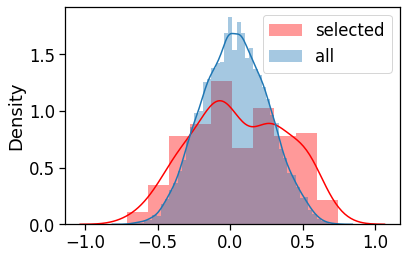

In [758]:
selected = subsum[['%s_%s'%(x,stat) for x in genes if x in gxp.index]].mean()
allrs = subsum[[x for x in subsum.columns if '_%s'%stat in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

In [272]:
# for x in [x.split('_r')[0] for x in sig]:
#     print(x)

In [759]:
sig = []
thr = round(len(allrs)*0.025)
cil = allrs.sort_values().values[thr]
ciu = allrs.sort_values().values[-thr]
print('CI:',cil,ciu)
for x in selected.index:
    if selected[x] >= ciu or selected[x] <= cil:
        sig.append(x)
print('# significant:',len(sig))
print(sig)

CI: -0.40218253968253975 0.47546296296296287
# significant: 53
['ME1_rho', 'MGAT4C_rho', 'RSPO4_rho', 'CNGB1_rho', 'GFAP_rho', 'NKAIN4_rho', 'SCN7A_rho', 'SGSH_rho', 'SLC26A11_rho', 'GOLT1A_rho', 'CHODL_rho', 'NWD1_rho', 'PCBD1_rho', 'DBX2_rho', 'RASL12_rho', 'WDR66_rho', 'CXorf57_rho', 'GPR143_rho', 'AQP1_rho', 'FERMT1_rho', 'PCDH17_rho', 'RGS22_rho', 'LRRC36_rho', 'SCN9A_rho', 'KLHL13_rho', 'PIRT_rho', 'LRRN1_rho', 'VWA5A_rho', 'SIX3_rho', 'VAT1L_rho', 'HSPB8_rho', 'KCNA5_rho', 'ZIC1_rho', 'ZMYND10_rho', 'CPLX2_rho', 'COX7A1_rho', 'ST3GAL6_rho', 'TBR1_rho', 'SEMA7A_rho', 'FAM13A_rho', 'NFIC_rho', 'BID_rho', 'CABP1_rho', 'PLEKHM2_rho', 'ATP2B2_rho', 'UBE2QL1_rho', 'TSPAN1_rho', 'BEND6_rho', 'KLF13_rho', 'CNKSR2_rho', 'MICAL2_rho', 'NDRG3_rho', 'SCRT1_rho']


In [ ]:
# vis_pass = ['MBP','LIMS2','WDR78','LDHD','TPP3','ID4','MAOB',
#            'HES5','TRPS1','CAPB1','DBX2','RASL12','FERMT1',
#            'SCN9A','KLHL13','VWA54']

In [41]:
# for gene in sig:
#     g=sns.lmplot(x='log_age_months',y=gene,
#             #hue='gender',
#             lowess=True,
#              #scatter_kws={'color':'k'},
#            data=subsum)
#     plt.title(gene.split('_')[0])
#     plt.show()

In [760]:
c2ss = pandas.DataFrame(subsum[[x for x in subsum.columns[20:] if x.split('_')[-1] == stat and \
                                                        x.split('_')[0] in genes]],
                       copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

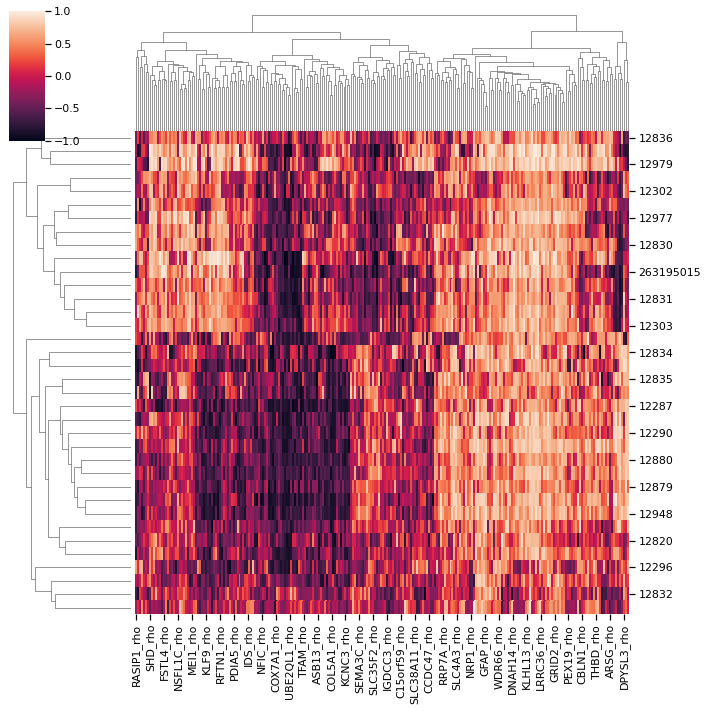

In [761]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss)

In [305]:
subsum.loc[g.data2d.index]['age']

12836        21 pcw
13058        16 pcw
12979        19 pcw
12949         9 pcw
12302         8 pcw
12833        24 pcw
12977        16 pcw
12889        16 pcw
12830        17 pcw
12365        13 pcw
263195015    12 pcw
12980        13 pcw
12831        12 pcw
12295        13 pcw
12303        12 pcw
12304        37 pcw
12834         4 yrs
12890         8 yrs
12835        11 yrs
13057         8 yrs
12287        23 yrs
12886         1 yrs
12290        21 yrs
12837        36 yrs
12880        40 yrs
12288        13 yrs
12879        37 yrs
12960        30 yrs
12948        19 yrs
12299        10 mos
12820         4 mos
12841         4 mos
12296         3 yrs
12984         2 yrs
12832         3 yrs
12300        18 yrs
Name: age, dtype: object

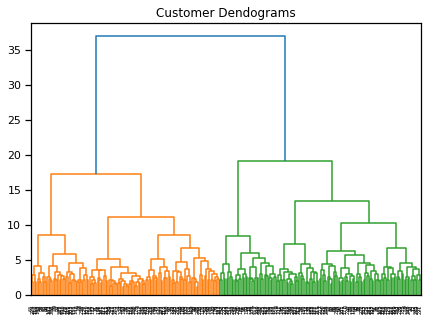

In [762]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(7, 5))
plt.title("Customer Dendograms")
link = shc.linkage(c2ss.T.values, method='ward')
dend = shc.dendrogram(link)

In [582]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

csol = pandas.DataFrame()
for i,k in enumerate(range(2,100)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

<AxesSubplot:xlabel='k', ylabel='sil_score'>

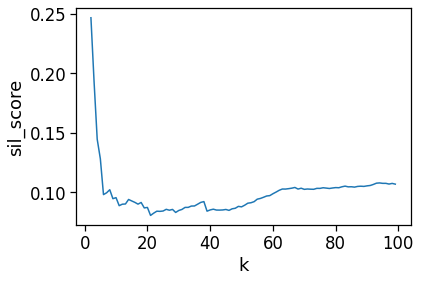

In [583]:
sns.lineplot(x='k',y='sil_score',data=csol)

In [ ]:
peaks = [2,8,12,38]

<AxesSubplot:>

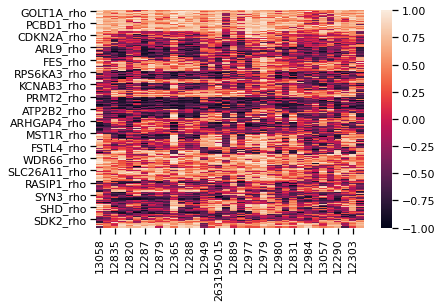

In [763]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=38, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sns.heatmap(data.sort_values('labels')[data.columns[:-1]])

In [764]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

cluster0  cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  \
13058  0.828571  0.671429  0.638089 -0.168831  0.580952  0.577143 -0.136508   
12833  0.643056  0.424190  0.264133 -0.434367  0.055556  0.121667 -0.176042   
12835  0.614583  0.321429 -0.295455 -0.668831 -0.422619  0.253571 -0.492063   
12960  0.697031 -0.020833 -0.083333 -0.720788  0.019444  0.711667 -0.729630   
12820  0.452381  0.040179 -0.152597 -0.139610 -0.160714  0.021429 -0.293651   

       cluster7  cluster8  cluster9  ...  Age_Period  MacroStructure  \
13058  0.200000 -0.118367 -0.150000  ...          p4         Frontal   
12833 -0.130000  0.016667 -0.231250  ...          p6          Limbic   
12835 -0.142857 -0.326531  0.669643  ...         p11         Frontal   
12960  0.463333 -0.616667  0.545833  ...         p12        Temporal   
12820  0.207143 -0.341837  0.035714  ...          p8        Temporal   

       MacroStructure2  NT_Segment  Sensorifugal  age_level  age_in_months  \
13058          Frontal        Tele   Association          4       3.678161   
12833           Limbic        Tele   Association          8       5.517241   
12835          Frontal        Tele   Association         20     132.000000   
12960         Temporal        Tele   Association         27     360.000000   
12820         Temporal        Tele   Association         13       4.000000   

       log_age_months  age_in_weeks  log_age_weeks  
13058        1.302413        16.000       2.772589  
12833        1.707878        24.000       3.178054  
12835        4.882802       611.105       6.415269  
12960        5.886104      1599.105       7.377199  
12820        1.386294        56.485       4.033975  

[5 rows x 58 columns]

-0.159


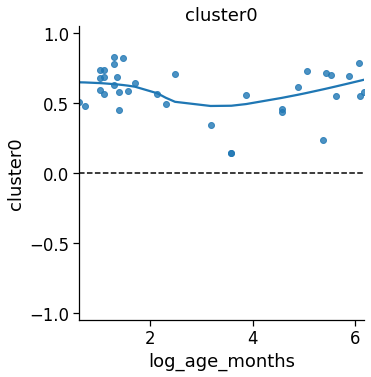

-0.52


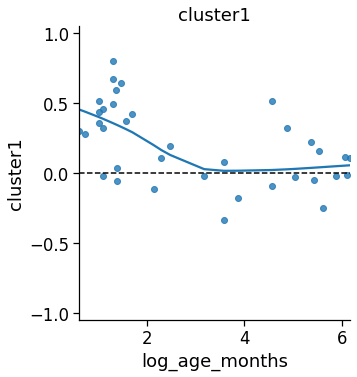

-0.7


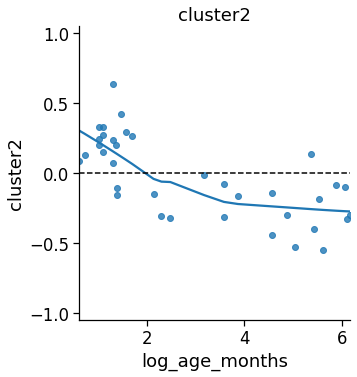

-0.742


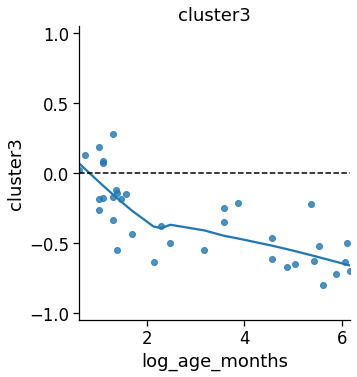

-0.074


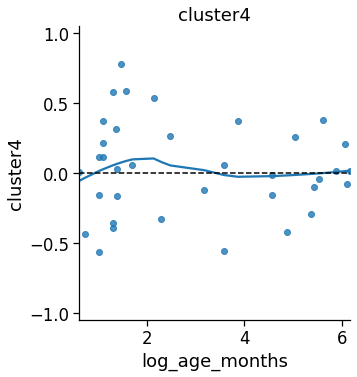

0.524


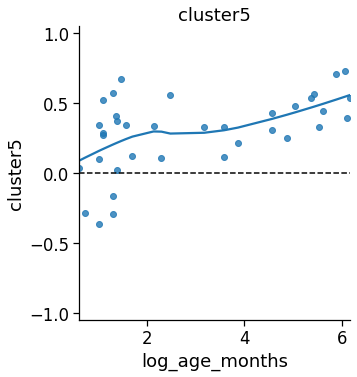

-0.224


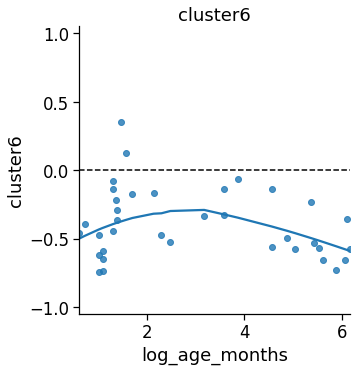

0.003


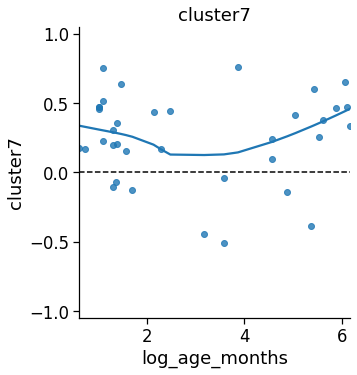

-0.711


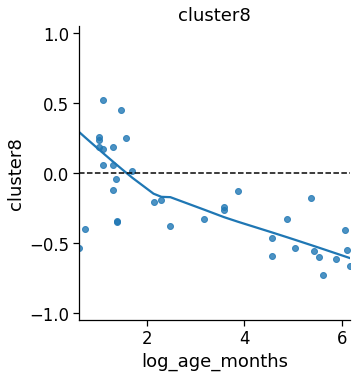

0.41


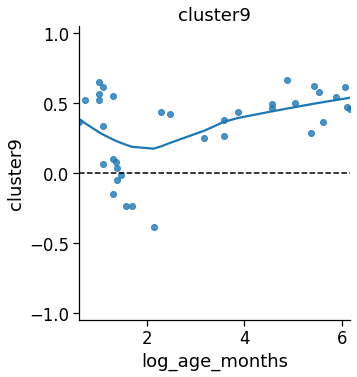

-0.227


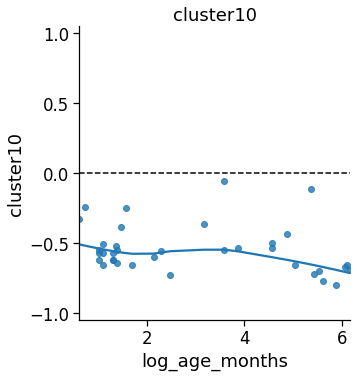

-0.311


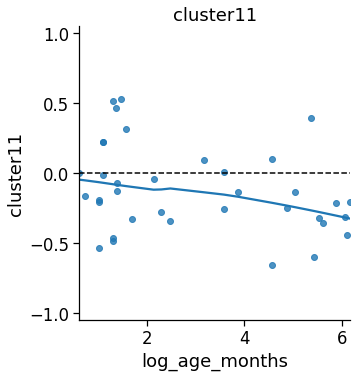

-0.736


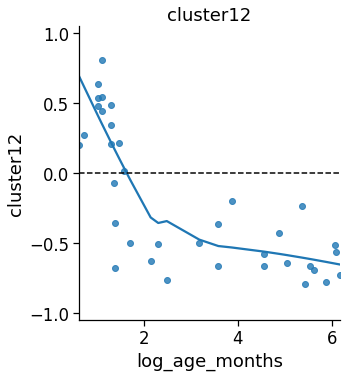

0.051


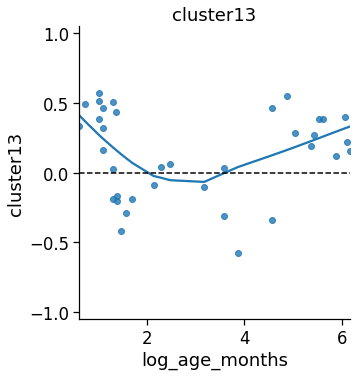

0.813


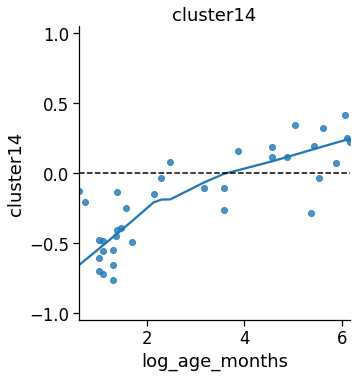

0.224


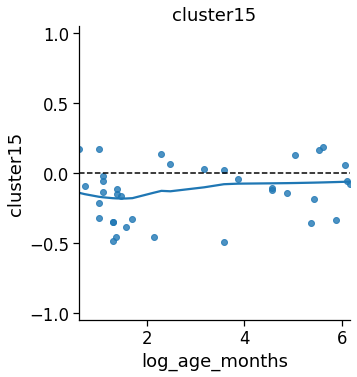

-0.863


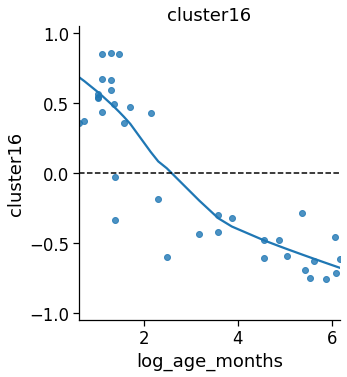

-0.708


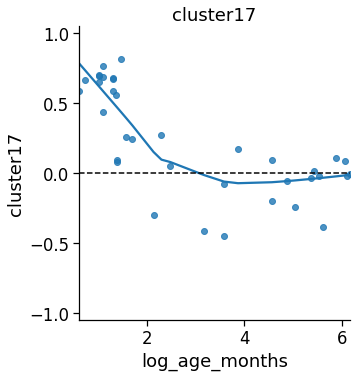

-0.295


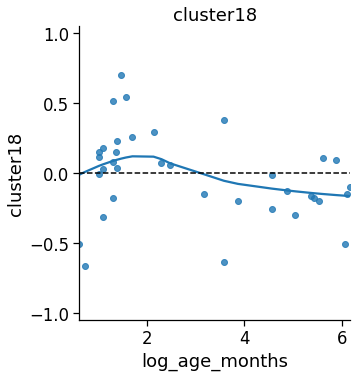

0.696


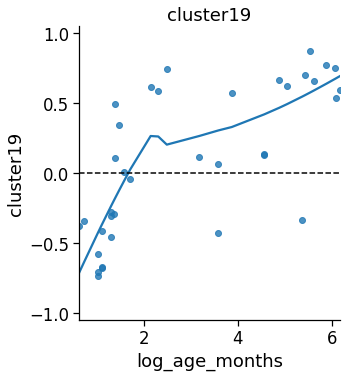

-0.293


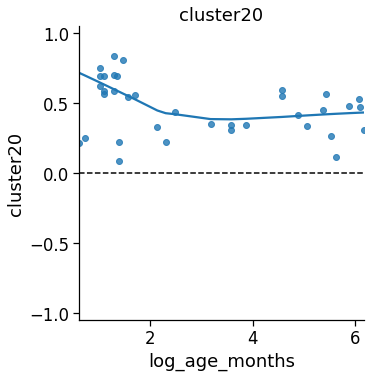

0.206


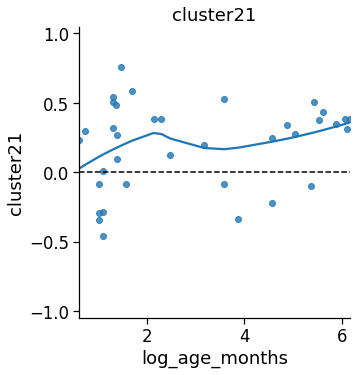

0.21


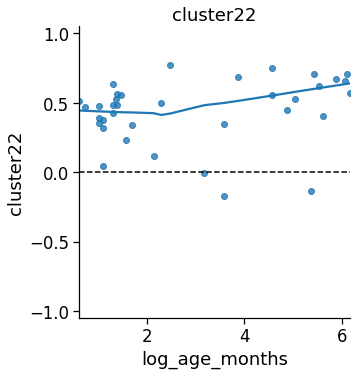

-0.312


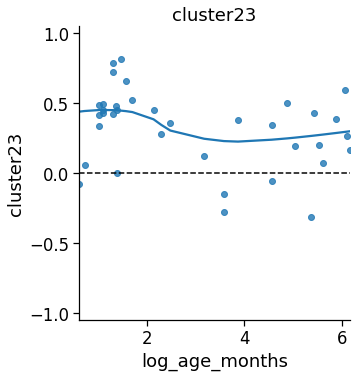

-0.344


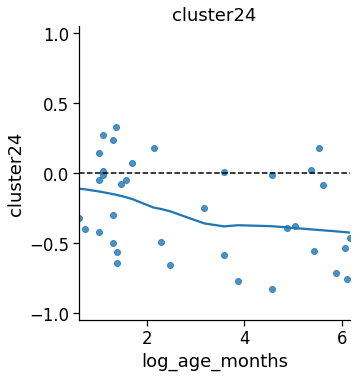

-0.116


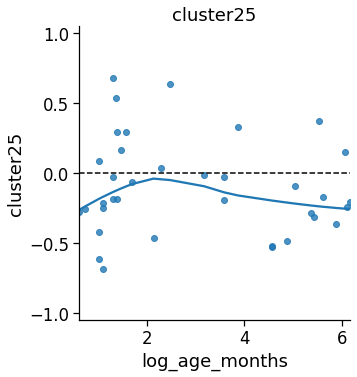

0.222


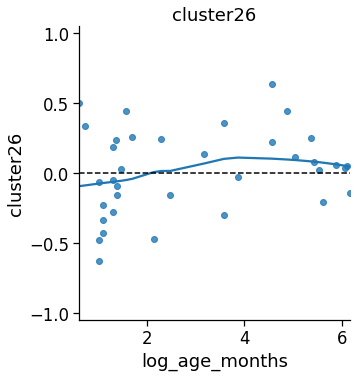

0.859


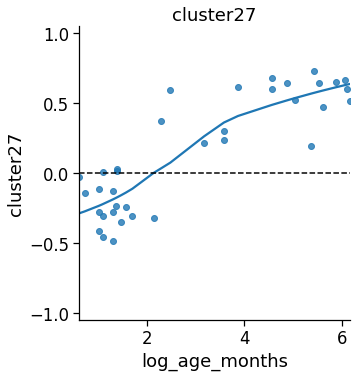

-0.297


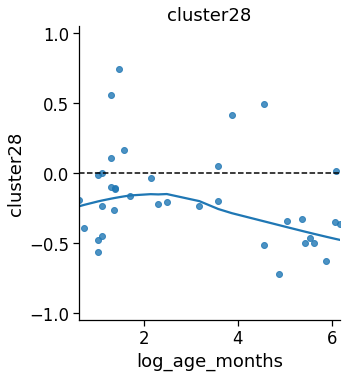

-0.656


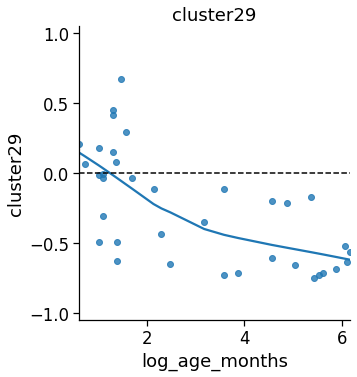

-0.536


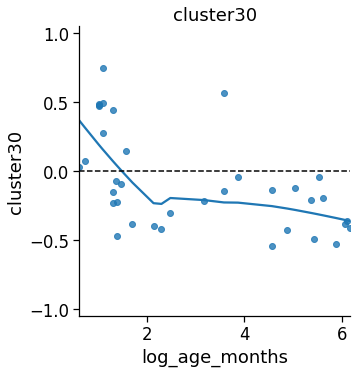

-0.892


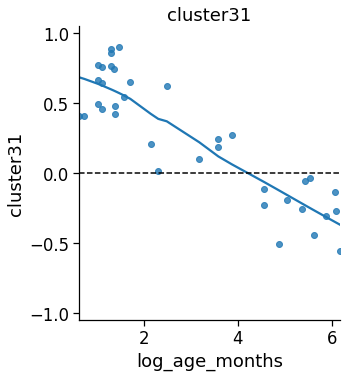

-0.598


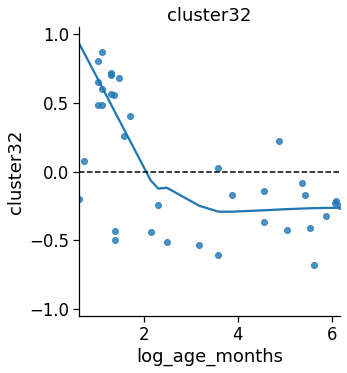

-0.593


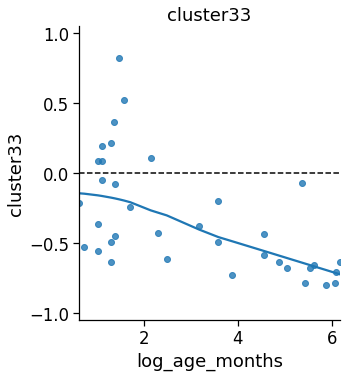

0.381


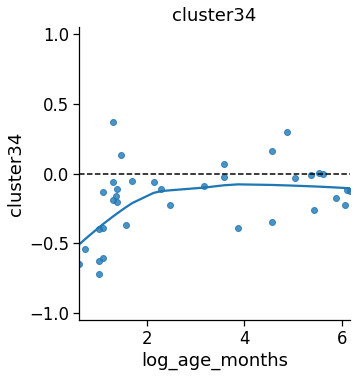

0.518


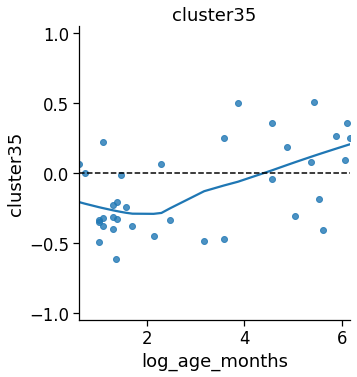

0.151


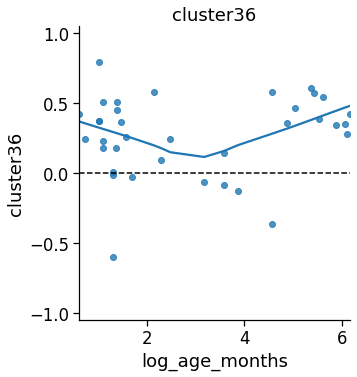

0.555


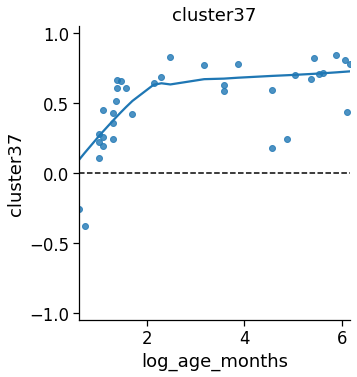

In [593]:
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    r,p = stats.pearsonr(cplots[cluster].values,cplots.log_age_months.values)
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    print(round(r,3))
    plt.show()

In [ ]:
[0,5?,7?,9?,10,13?,20?,22,23?]

In [766]:
cplots.loc[:,'ind'] = cplots.index

In [767]:
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_months'] = cplots.log_age_months.tolist() * len(tall.variable.unique())

In [769]:
colors = []
for clust in tall.variable.unique():
    r,p = stats.pearsonr(cplots[clust].values,cplots.log_age_months.values)
    if clust in ['cluster0','cluster10','cluster22']:
        colors.append('black')
    elif r < 0:
        colors.append('lightsteelblue')
    else:
        colors.append('lightcoral')

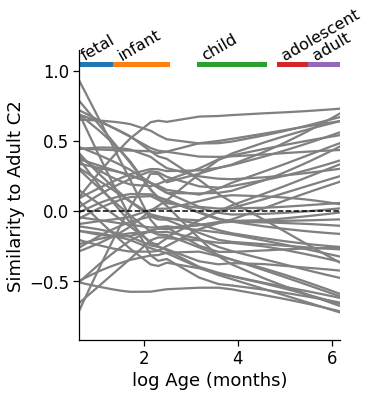

In [863]:
from matplotlib.collections import LineCollection

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,data=tall)
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k38_gray.pdf'),bbox_inches='tight')

#### Criteria
* Mostly genes from one tail
* Goes in the expected direction
* Reaches r > 0.5 at some point

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='log_age_months', ylabel='value'>

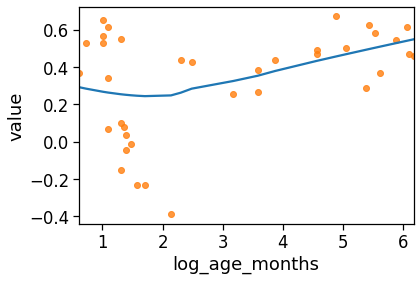

In [615]:
c = 9
jnk = g.ax.lines[c]
sns.regplot(jnk.get_data()[0],jnk.get_data()[1],lowess=True,scatter=False)
sns.regplot(x='log_age_months',y='value',data=tall[tall.variable=='cluster%s'%c],
           fit_reg=False)

In [772]:
crit = pandas.DataFrame(data['labels'].unique())

### CHANGE THIS DEPENDING ON COMPONENT
posg = c2[c2.expr>0].gene_symbol
negg = c2[c2.expr<0].gene_symbol

flats = [0,10,22]
for clust in data['labels'].unique():
    cluster = 'cluster'+str(clust)
    cgenes = [x.split('_')[0] for x in data[data.labels==clust].index]
    npos = len([x for x in cgenes if x in posg])
    nneg = len([x for x in cgenes if x in negg])
    
    # mostly genes from one tail
    if (npos+0.001) / (nneg+0.001) > 3:
        direction = 'pos'
    elif (npos+0.001) / (nneg+0.001) < 0.33:
        direction = 'neg'
    else:
        direction = 'ambiguous'
    crit.loc[clust,'direction'] = direction
    
    # goes in the expected direction
    r,p = stats.spearmanr(cplots[cluster].values,cplots.log_age_months.values)
    mn = cplots[cplots.log_age_months>4][cluster].values.mean() # mean signal post childhood
    if clust in flats:
        cor = 'flat'
    elif r < 0:
        cor = 'neg'
    else:
        cor = 'pos'
    crit.loc[clust,'correlation'] = cor
    crit.loc[clust,'rho'] = r
    if mn > 0:
        mean = 'pos'
    else:
        mean = 'neg'
    crit.loc[clust,'meandir'] = mean
    crit.loc[clust,'mean'] = mn
    if mean == direction:
        crit.loc[clust,'mean_match'] = 1
    else:
        crit.loc[clust,'mean_match'] = 0
    if cor == direction:
        crit.loc[clust,'cor_match'] = 1
    else:
        crit.loc[clust,'cor_match'] = 0
    
    # Reaches r > 0.5 at some point
    fitted = g.ax.lines[clust] # this comes from the multiline lmplot a few cells up
    max_r = np.max(abs(fitted.get_data()[1]))
    if max_r > 0.5:
        strength = True
        crit.loc[clust,'strenth_match'] = 1
    else:
        strength = False
        crit.loc[clust,'strenth_match'] = 0
    crit.loc[clust,'max_r'] = max_r
    
    # all criteria
    hit = False
    if cor == 'flat':
        hit = True
    else:
        if direction != 'ambiguous' and \
               crit.loc[clust,'mean_match'] == 1 and strength:
            hit = True
    if hit:
        crit.loc[clust,'hit'] = 1
    else:
        crit.loc[clust,'hit'] = 0
            
            

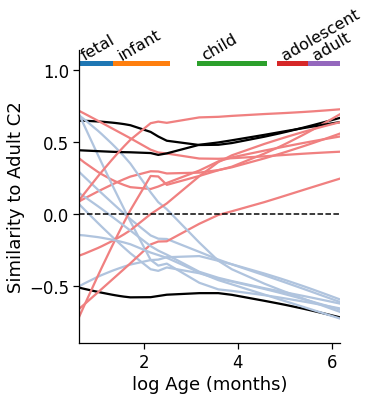

In [773]:
# derive colors and line styles
colors = []
for c,row in crit[crit.hit==1].iterrows():
    if row['correlation'] == 'flat':
        colors.append('black')
    elif row['direction'] == 'pos':
        colors.append('lightcoral')
    else:
        colors.append('lightsteelblue')

hits = ['cluster%s'%x for x in crit[crit.hit==1].index]
# plot
sns.set_context('notebook',font_scale=1.5)
g2=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=colors,
             legend=None,data=tall[tall.variable.isin(hits)])
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k38_postcrit.pdf'),bbox_inches='tight')

#### next criteria
* define peak
* define SD of variation
* find the point in lifespan where trajectory ceases to be different from peak

#### scratch that
* Divide r into age epochs
* find binary sig diffs between epochs for r
* categorize based on that

In [375]:
cplots.Age_Stage.value_counts()

fetal         16
child          6
adult          6
infant         4
adolescent     4
Name: Age_Stage, dtype: int64

<AxesSubplot:xlabel='Age_Stage'>

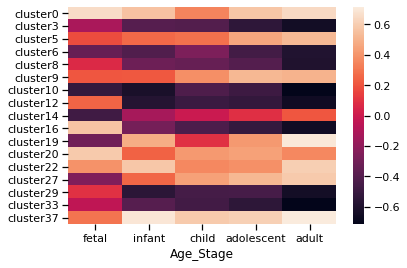

In [601]:
sns.set_context('notebook',font_scale=1)
order = ['fetal','infant','child','adolescent','adult']
sns.heatmap(cplots.groupby('Age_Stage')[hits].mean().T[order])

In [602]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [603]:
cplots.Age_Stage.value_counts()

fetal         16
child          6
adult          6
infant         4
adolescent     4
Name: Age_Stage, dtype: int64

In [604]:
groupdifs = []

for clust in hits :
    print('working on',clust)
    for i in range(1):#00):
        # subsample so all categories have 4 subjects
        ss = balanced_subsample(cplots.Age_Stage)
        ssdf = cplots.loc[ss]
        # get omnibus stats
        F,p = stats.f_oneway(ssdf[ssdf.Age_Stage=='fetal'][clust].values,
                  ssdf[ssdf.Age_Stage=='infant'][clust].values,
                  ssdf[ssdf.Age_Stage=='child'][clust].values,
                  ssdf[ssdf.Age_Stage=='adolescent'][clust].values,
                  ssdf[ssdf.Age_Stage=='adult'][clust].values)
        # store tukey hd output
        output = pairwise_tukeyhsd(cplots[clust],cplots.Age_Stage)
        gdiff = pandas.DataFrame(np.array(output.summary().data[1:]),
                        columns = output.summary().data[0])
        # annotate and index
        gdiff.loc[:,'F'] = F
        gdiff.loc[:,'p'] = p
        gdiff.loc[:,'cluster'] = clust
        gdiff.loc[:,'i'] = i
        groupdifs.append(gdiff)
# combine all results
results = pandas.concat(groupdifs)

working on cluster0
working on cluster3
working on cluster5
working on cluster6
working on cluster8
working on cluster9
working on cluster10
working on cluster12
working on cluster14
working on cluster16
working on cluster19
working on cluster20
working on cluster22
working on cluster27
working on cluster29
working on cluster33
working on cluster37


In [605]:
def func(x):
    if x == 'False':
        return 0
    else:
        return 1

results.loc[:,'reject'] = results.reject.apply(func).values

In [606]:
for i,row in results.iterrows():
    results.loc[i,'group'] = '%s_%s'%(row['group1'],row['group2'])

I checked and, despite having random samples, every iteration had the same results (not surprising given most of the variation was coming from large effect size group

In [607]:
jnk = pandas.DataFrame(results[results.i==0])

In [608]:
jnk.loc[:,'ind'] = range(len(jnk))
jnk.pivot(index='group',columns='cluster',values='reject')

cluster            cluster0  cluster10  cluster12  cluster14  cluster16  \
group                                                                     
adolescent_adult          0          0          0          0          0   
adolescent_child          0          0          0          0          0   
adolescent_fetal          0          0          1          1          1   
adolescent_infant         0          0          0          0          0   
adult_child               1          1          0          0          0   
adult_fetal               0          0          1          1          1   
adult_infant              0          0          0          0          1   
child_fetal               1          0          1          1          1   
child_infant              0          0          0          0          0   
fetal_infant              0          0          1          1          1   

cluster            cluster19  cluster20  cluster22  cluster27  cluster29  \
group                                                                      
adolescent_adult           0          0          0          0          0   
adolescent_child           0          0          0          0          0   
adolescent_fetal           1          0          0          1          1   
adolescent_infant          0          0          0          0          0   
adult_child                1          0          0          0          0   
adult_fetal                1          1          0          1          1   
adult_infant               0          0          0          1          0   
child_fetal                0          0          0          1          1   
child_infant               0          0          0          0          0   
fetal_infant               1          1          0          1          1   

cluster            cluster3  cluster33  cluster37  cluster5  cluster6  \
group                                                                   
adolescent_adult          0          0          0         0         0   
adolescent_child          0          0          0         0         0   
adolescent_fetal          1          0          0         0         0   
adolescent_infant         0          0          0         0         0   
adult_child               0          0          0         0         0   
adult_fetal               1          1          1         0         0   
adult_infant              0          0          0         0         0   
child_fetal               1          0          0         0         0   
child_infant              0          0          0         0         0   
fetal_infant              0          0          1         0         0   

cluster            cluster8  cluster9  
group                                  
adolescent_adult          0         0  
adolescent_child          0         0  
adolescent_fetal          1         0  
adolescent_infant         0         0  
adult_child               0         0  
adult_fetal               1         0  
adult_infant              0         0  
child_fetal               1         0  
child_infant              0         0  
fetal_infant              1         0

* C0: Child - Adult (flat)
* C2: Fetal - Child
* C5: - (Fetal - Infant)
* C6: - (non-mon)
* C8: Fetal - Infant
* C9: - (non-mon)
* C10: Child - Adult (flat)
* C12: Fetal - Infant
* C14: Fetal - Infant
* C16: Fetal - Infant - Adult
* C19: Fetal - Infant
* C20: Fetal - Infant
* C22: - (Flat)
* C27: Fetal - Infant - Adult
* C29: Fetal - Infant
* C33: Fetal - Adult
* C37: Fetal - Infant

In [785]:
cats = dict(zip(hits,['fetal_nl','child','infant','fetal_nl','infant','fetal_nl',
                      'fetal_nl','infant','infant','postchild','infant','infant','fetal_nl',
                      'postchild','infant','postchild','infant']))
colos = dict(zip(['fetal_nl','infant','child','postchild'],
                sns.color_palette('tab20',4)))
pal = [colos[x] for x in cats.values()]

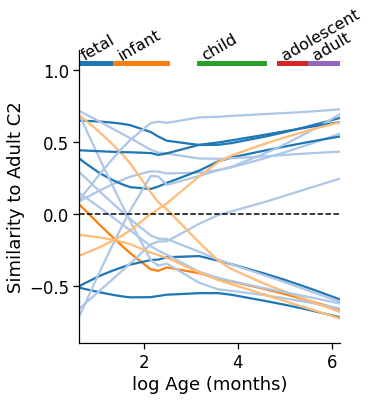

In [787]:
# plot
sns.set_context('notebook',font_scale=1.5)
g2=sns.lmplot(x='log_age_months',y='value',
            hue='variable',lowess=True,
             markers='',palette=pal,
             legend=None,data=tall[tall.variable.isin(hits)])
plt.ylabel('Similarity to Adult C2')
plt.xlabel('log Age (months)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'cluster_timelinesC2_k38_posttiming.pdf'),bbox_inches='tight')

In [834]:
for i,row in crit.iterrows():
    c = 'cluster%s'%i
    if c in cats.keys():
        crit.loc[i,'category'] = cats[c]

In [836]:
keepers = []
for clust in crit[crit.category=='child'][0].values:
    jnk = data[data.labels==clust]
    for x in jnk.index:
        j2 = x.split('_')[0]
        #print(j2)
        keepers.append(j2)
    #print('\n\n')
np.array(keepers)

array(['IDS', 'PDIA5', 'LXN', 'SMPX', 'PPM1H', 'CTNNAL1', 'C5orf24',
       'ARL9', 'RAD54B', 'LYRM4', 'MYBPHL'], dtype='<U7')

In [622]:
keepers = []
for clust in crit[crit.category=='postchild'][0].values:
    jnk = data[data.labels==clust]
    for x in jnk.index:
        j2 = x.split('_')[0]
        #print(j2)
        keepers.append(j2)
    #print('\n\n')
np.array(keepers)

array(['ARHGAP4', 'GRP', 'WTIP', 'ST20', 'PRR5', 'SCN1B', 'TFAM', 'DCPS',
       'NNMT', 'KCNAB3', 'RTKN2', 'PRC1', 'ENOX1', 'SOX11', 'CACNA1H',
       'DDAH2'], dtype='<U7')

In [572]:
jnk = subsum[subsum.Age_Stage.isin(['adult','adolescent'])]
jnk = jnk[[x for x in jnk.columns if 'rho' in x]].mean()
corgenes = [x.split('_')[0] for x in jnk[jnk>0.5].index]


In [799]:
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

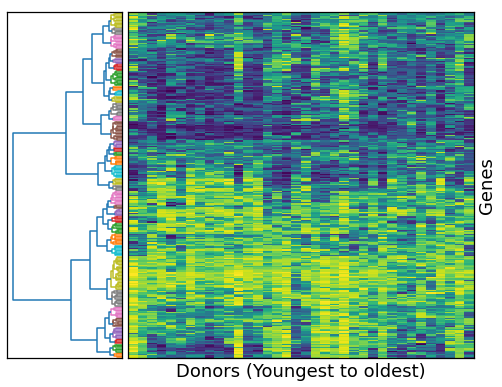

In [809]:
# Dendrogram that comes to the left

D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

fig = plt.figure(figsize=(8,8))
# Add an axes at position rect [left, bottom, width, height]
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
# orientation='left' is reponsible for making the 
# dendrogram appear to the left
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=4)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="viridis")
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')


plt.savefig(os.path.join(fig_dir,'DendoC2.pdf'),bbox_inches='tight')
plt.show()

In [624]:
# keepers = []
# for clust in [0,1,2]:
#     jnk = data[data.labels==clust]
#     for x in jnk.index:
#         j2 = x.split('_')[0]
#         print(j2)
#         keepers.append(j2)
#     print('\n\n')

In [826]:
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
bigdf = pandas.read_csv('/Users/jacobv/Downloads/bigdf.csv',index_col=0)
probes = probes[probes.gene_symbol.isin(bigdf.columns)]

In [840]:
x

92949

In [849]:
jnkF = ['HS3ST1', 'ATP4A', 'PLEKHM2', 'KCNC1', 'KCNC3', 'SCRT1', 'THEMIS',
       'PELI3', 'EIF4E1B', 'CAMK1D', 'ASB13', 'KCNG1', 'ADAMTSL1',
       'FABP5P3', 'ATP2B3', 'NDRG3', 'NFIC', 'PPFIA4', 'BEND6', 'ZBTB8A',
       'GLIS1', 'RPS6KA3', 'SECISBP2', 'SDK2', 'SEMA3C', 'ANKRD50',
       'ROBO2', 'HRH3', 'SLC4A3', 'TSPAN2', 'AMIGO2', 'SKAP1', 'SLC26A11',
       'SGSH', 'GPRIN2']
jnkI = ['IDS', 'PDIA5', 'LXN', 'SMPX', 'PPM1H', 'CTNNAL1', 'C5orf24',
       'ARL9', 'RAD54B', 'LYRM4', 'MYBPHL', 'BID', 'ST3GAL6', 'TSPAN1',
       'MICAL2', 'TBR1', 'SEMA7A', 'FAM13A', 'CPLX2', 'CNKSR2', 'ATP2B2',
       'CABP1', 'COX7A1', 'KLF13', 'UBE2QL1', 'WISP2', 'FABP5', 'GPX3',
       'ADCYAP1R1', 'PITPNC1', 'CYB5R1', 'MT1F', 'RYR3', 'ITPKC', 'FRAT1',
       'FRAT2', 'CUX1', 'DSP', 'ARSG', 'LPP', 'SLC38A11', 'FES', 'RCSD1',
       'PCSK5', 'NTSR1', 'SLC35F2', 'PAX8', 'SYT6', 'IL17RD', 'ADAMTS9',
       'NAV2', 'TSKU', 'AEBP1', 'SLC27A6', 'PRRX1', 'TGFBI', 'COL21A1',
       'APLNR', 'GXYLT2', 'NUPR1', 'THBD', 'TCEA3', 'CENPJ', 'CCDC88B',
       'SYCP2', 'COL27A1']
jnkC = ['ARHGAP4', 'GRP', 'WTIP', 'ST20', 'PRR5', 'SCN1B', 'TFAM', 'DCPS',
       'NNMT', 'KCNAB3', 'RTKN2', 'PRC1', 'ENOX1', 'SOX11', 'CACNA1H',
       'DDAH2'] + ['IDS', 'PDIA5', 'LXN', 'SMPX', 'PPM1H', 'CTNNAL1', 'C5orf24',
       'ARL9', 'RAD54B', 'LYRM4', 'MYBPHL']
for x in jnkC: print(x)
# string = ''
# for x in jnk: 
#     string+=(x+' ')
# print(string)
# j2 = probes[probes.gene_symbol.isin(jnkI)].groupby('gene_symbol'
#                                             ).entrez_id.first().values.astype(int)
# string = ''
#for x in j2: print(x)
# for x in j2: 
#     string+=(str(x)+' ')
# print(string)

ARHGAP4
GRP
WTIP
ST20
PRR5
SCN1B
TFAM
DCPS
NNMT
KCNAB3
RTKN2
PRC1
ENOX1
SOX11
CACNA1H
DDAH2
IDS
PDIA5
LXN
SMPX
PPM1H
CTNNAL1
C5orf24
ARL9
RAD54B
LYRM4
MYBPHL


In [831]:
# j2 = probes.groupby('gene_symbol'
#                    ).entrez_id.first().values.astype(int)
# for x in j2: print(x)

1
2
144568
53947
8086
65985
126767
51166
195827
79719
22848
14
15
441376
16
57505
132949
60496
10157
26574
9625
18
19
10349
79963
20
21
23461
23460
10347
10351
10350
5243
23456
10058
22
11194
23457
4363
89845
94160
10057
368
6833
10060
225
5825
5826
6059
23
10061
55324
9619
9429
64137
64241
84696
55347
83451
26090
145447
84945
25864
84836
11057
171586
63874
51099
57406
79575
10006
10152
51225
25
27
3983
84448
22885
29
29777
80325
25841
30
10449
31
32
80724
84129
27034
28976
33
34
36
37
176
23527
116983
38
39
64746
79777
91452
84320
414149
84680
65057
1636
340485
55331
43
22985
47
48
50
26027
55856
10965
122970
11332
10005
23597
51
8309
8310
52
53
54
51205
55
49
84519
23205
80221
197322
2180
2181
2182
23305
116285
123876
54988
84532
55902
79611
58
59
60
345651
70
71
648740
72
86
51412
81569
87
88
81
55860
10121
10120
10097
10096
57180
440888
79913
64431
93973
90
91
130399
92
93
94
91703
97
98
100
161931
161823
102
4185
8751
6868
8728
8748
53616
8745
10863
11086
80332
8756
101
8754
9510


836
837
838
839
840
841
9994
842
844
831
54897
847
440278
857
858
9139
863
865
867
868
79872
869
147381
140689
873
874
84869
55871
220869
10951
84733
11335
8535
23468
23466
23492
25776
54862
200014
57545
55749
147372
92922
79839
388389
29903
203260
256309
153733
29070
93233
84317
150275
151903
90060
79635
160857
115098
202243
90693
133957
81576
79879
64753
339230
165055
64770
285025
84865
339184
57639
130940
91050
80071
115948
100129792
283152
645811
550631
339965
100130274
28952
149473
55246
25901
79140
83643
728621
91057
339829
55036
124808
57003
152137
79714
284001
131076
29080
8030
729440
85478
285331
80323
26112
221016
83446
64925
91409
84318
124093
83987
151887
79780
338657
114800
11007
317762
79080
55231
55704
283234
440193
26093
60492
55297
80212
54520
257236
90324
54535
881
885
887
6361
6363
6347
6366
6367
6369
6370
10850
56477
83605
8900
891
57820
85417
892
595
894
896
23582
898
9134
899
900
901
902
10983
645121
54619
8812
57018
81669
10309
904
905
219771
151195
1230
2826
123

84661
1806
1808
1809
10570
56896
1810
55332
128338
10589
1812
1813
1815
4733
1819
1821
1826
57453
79075
29940
92126
79980
1832
667
11034
25778
92675
1837
1838
84062
56986
285605
1840
113878
441263
196403
151636
23220
1841
64118
56931
11062
1843
11221
8446
11266
11072
128853
80824
150290
142679
1844
56940
54935
78986
285193
1845
1846
1848
1849
1850
1852
1854
1855
1856
1857
84332
54808
1778
1780
1781
51143
1783
79659
51626
8655
140735
83658
83657
6993
6990
1859
9149
8445
8444
8798
8291
391475
22873
9666
1869
1871
1874
1875
1876
1877
85403
55840
55837
124454
9166
1879
57593
10148
55096
10969
10682
84650
11319
1889
9427
1891
55862
55268
79746
1892
1893
1842
641700
51295
1894
1896
128178
80153
23644
9695
80267
8721
10085
1906
1908
1909
1910
8411
8726
1915
1917
1933
1936
1937
1938
29904
60678
80820
79645
90141
84288
64800
84455
2202
30008
151651
114327
80258
80303
79180
1942
1943
1944
1945
1946
1947
1948
1949
23167
22979
10278
9343
93556
51162
1956
54583
112399
1958
1959
1960
1961
23301
2541

2946
442245
2947
2948
2949
9446
119391
2950
2952
2954
219409
79712
2957
2958
2959
2960
2961
2962
2963
2965
653238
2967
2968
404672
2969
9569
2971
2975
2976
9330
9329
9328
112495
9567
85865
54676
84705
23560
8225
29083
2979
2980
2981
2977
60558
2987
51454
2990
642006
653188
387751
727936
2992
8908
2995
2997
64412
3002
2999
3004
3005
341567
8971
55766
94239
3014
9555
55506
3015
391769
3021
9563
23498
22927
57531
26061
3033
3030
3032
3029
84264
57817
9464
9001
1404
60484
404037
768096
283254
3035
23438
8520
115106
55142
79441
54930
54801
55559
93323
84868
10456
3039
3040
3043
1839
3047
3042
26959
3049
10767
3050
3052
3054
54985
29915
414777
54435
80868
3055
3059
348980
610
57657
10021
10866
3060
3061
10870
3065
83933
79885
3066
8841
9759
10014
10013
51564
55869
9734
3067
51020
374659
3068
154150
84064
81932
3069
139324
55127
55027
399671
25938
54497
63897
50865
23593
51696
25831
143279
79654
23072
57520
57493
92797
3070
113510
9931
51409
220296
9843
8925
8924
8916
26091
51191
55008
9709
6

503693
9361
83752
91694
164832
79836
4014
125336
4016
4017
84695
1902
9170
57121
10161
79888
54947
254531
9926
23175
9663
64900
4023
4026
9404
987
23143
57631
84859
100507055
57622
57497
79414
78999
145581
26018
9860
121227
4035
26020
84918
29967
53353
4036
55805
4037
4038
4041
4040
7804
4043
10128
55227
9684
131578
10234
79442
55222
10233
441381
389816
80313
123355
26231
81543
2615
151827
55282
374819
55073
114659
126755
127495
116135
64101
55631
10489
115353
201255
90506
57470
54839
94030
57689
219527
115399
255252
116064
55379
23639
65999
220416
339977
57554
100130733
56262
23507
84230
55144
85444
9208
9209
84125
79705
120892
57633
10446
54674
347730
26045
347731
80059
90678
654429
222229
4045
55341
27257
84967
134353
124801
26065
149986
57819
27258
25804
23658
11157
51690
4046
51599
4047
7940
4049
4048
4050
1241
56413
4052
4053
4054
8425
4055
4056
4058
84946
55692
286343
7798
338645
56925
8581
4061
58496
80741
4062
9450
285780
4063
23643
55646
129530
4066
4067
66004
116372
137797
2

348995
10762
53371
23636
79902
4927
9688
4928
11097
26471
116150
10204
4931
284434
10482
56000
64359
158046
91775
30010
11249
11248
11247
29107
55916
60506
220323
4938
4940
4942
4946
4947
51686
84033
23363
4948
79629
54940
132299
100506658
4952
4953
4957
57489
161753
284451
8481
4967
55753
55239
79676
11054
79627
4968
8473
729082
29789
10439
93145
118427
10562
169611
25903
56944
116448
10215
4973
115209
4974
3175
9480
4976
80207
93377
50863
4983
26873
23596
94233
4986
4987
4988
10133
341276
144124
442194
26534
26538
284433
219960
390201
26531
79290
347468
401994
8386
8387
26219
135941
442361
338755
391191
127623
26716
7932
284521
391192
391190
388762
391196
254879
343171
441932
284383
4994
4995
390197
124538
219983
390431
340980
119774
390077
120787
219965
26341
26338
81696
403282
390326
390261
89883
283491
26648
219445
79315
219858
84876
80228
93129
220064
4999
5000
5004
94101
29095
94103
10956
5007
23762
114884
114885
114876
9885
26031
114879
114880
114882
114883
126014
55644
64172
7

10268
5901
5902
57610
64901
5903
8498
202151
26953
10048
5905
29098
5906
5908
5909
5910
5911
5912
57826
2889
9693
10411
11069
9771
51735
51195
65059
5913
5914
5915
5916
5918
5919
5920
5917
57038
5921
5922
22821
401331
8437
9462
64926
51655
23551
221002
153020
255426
5923
5924
10125
10235
25780
115727
54922
10633
91608
387496
65997
51285
11186
9770
283349
83937
83593
8045
11228
125950
55225
84839
5925
9821
57786
5928
5929
5930
5931
5932
10741
10616
79863
64080
5933
5934
8241
54033
10137
389677
10432
64783
29890
84991
92400
9904
55696
55147
221662
58517
64062
54439
55131
5935
155435
23029
55544
9584
5936
55285
79171
375287
129831
83759
10181
10180
9939
5937
5939
27303
27316
51634
494115
5947
5948
5950
116362
11030
348093
9978
149041
54542
1827
10231
11123
55213
1102
1104
55920
91433
25898
10171
5954
5955
57333
23186
283248
55758
92241
157506
51109
145226
112724
57665
8608
5959
201299
5962
9985
8434
5965
9401
9400
65055
51308
221035
80346
7905
92840
5966
5970
5971
768211
285613
5649
84957

9306
30837
6647
6648
6649
402381
6651
10580
8470
10174
114815
57537
22986
6653
6272
6654
6655
25928
6656
6663
6664
6666
9580
6665
64321
54345
6657
347689
11166
6658
6659
6660
55553
83595
30812
6662
6667
6672
3431
11262
93349
6668
6670
6671
389058
80320
121340
100131390
53340
124912
79582
6676
10615
9552
26206
9043
619455
6678
8404
6683
100505741
221178
132671
9825
64847
124044
132851
79029
54558
55812
65244
26010
28972
9789
60559
25803
285955
441272
442590
25876
79925
10290
374768
23013
80208
51324
6687
8877
56848
80309
6688
6689
10927
474343
169981
139886
6691
84651
646424
56907
84501
6693
83985
124976
201305
90853
6695
9806
50859
10418
10417
8405
339745
6696
56928
6697
161742
200734
399473
503542
6698
6702
6704
10252
10253
10251
81848
84926
283377
80176
84727
90864
92369
6709
6710
6711
6712
57731
51332
10558
9517
165679
144108
6713
8878
10011
55133
6714
10847
6715
79644
6720
6721
285672
6722
153443
57522
23380
9901
5552
6717
6723
6727
6728
6729
6730
6731
6726
6732
6733
26576
58477
84

7324
7325
140739
7327
7328
7329
51465
118424
3093
7332
9246
9040
7334
389898
63893
55585
92912
388165
134111
54926
27338
29089
7336
55284
65264
7337
89910
9690
9354
10277
56061
29914
5412
8266
59286
84993
134510
29855
254048
22888
7342
29979
29978
56893
197131
23304
130507
23352
51366
55148
80019
92181
7343
51035
127733
91544
165324
137886
23190
80700
26043
7993
7345
7347
51377
83549
7371
54963
7349
90226
7351
7352
55293
51506
51569
402682
55325
643763
7357
7358
7360
7365
7368
127933
29128
23074
115426
51720
80329
80328
8408
9706
25989
54986
7369
7372
9094
84747
23025
10497
440279
201294
55898
25972
90249
219699
8633
137970
85451
5976
26019
65110
65109
7379
7380
80761
7378
151531
139596
10975
7381
442454
7384
7385
7386
7388
440567
27089
9875
9816
8725
81605
7389
7390
55850
7391
7392
10083
83878
8615
7398
9100
8237
219333
8975
9097
9958
10600
11274
10869
9099
10868
27005
23326
23358
29761
389856
57646
9960
84749
100131733
57478
84669
23032
9736
57558
57602
57695
84640
10713
7375
55230
8